<a href="https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/af/examples/AF2Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AF2Rank
[AF2Rank](https://github.com/jproney/AF2Rank) implemented using ColabDesign. 

If you find useful, please cite:
- Roney, J.P. and Ovchinnikov, S., 2022. **State-of-the-Art estimation of protein model accuracy using AlphaFold**. [BioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.11.484043v3.full).

In [1]:
#@title ## setup
%%bash
if [ ! -d params ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1
  # for debugging
  ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign

  # alphafold params
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar | tar x -C params

  wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
  g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
fi

In [2]:
#@title import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from colabdesign import clear_mem, mk_af_model
from colabdesign.shared.utils import copy_dict

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import jax

def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')

  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  
  return o
  
def plot_me(scores, x="tm_i", y="composite", 
            title=None, diag=False, scale_axis=True, dpi=100, **kwargs):
  def rescale(a,amin=None,amax=None):  
    a = np.copy(a)
    if amin is None: amin = a.min()
    if amax is None: amax = a.max()
    a[a < amin] = amin
    a[a > amax] = amax
    return (a - amin)/(amax - amin)

  plt.figure(figsize=(5,5), dpi=dpi)
  if title is not None: plt.title(title)
  x_vals = np.array([k[x] for k in scores])
  y_vals = np.array([k[y] for k in scores])
  c = rescale(np.array([k["plddt"] for k in scores]),0.5,0.9)
  plt.scatter(x_vals, y_vals, c=c*0.75, s=5, vmin=0, vmax=1, cmap="gist_rainbow",
              **kwargs)
  if diag:
    plt.plot([0,1],[0,1],color="black")
  
  labels = {"tm_i":"TMscore of Input",
            "tm_o":"TMscore of Output",
            "tm_io":"TMscore between Input and Output",
            "ptm":"Predicted TMscore (pTM)",
            "i_ptm":"Predicted interface TMscore (ipTM)",
            "plddt":"Predicted LDDT (pLDDT)",
            "composite":"Composite"}

  plt.xlabel(labels.get(x,x));  plt.ylabel(labels.get(y,y))
  if scale_axis:
    if x in labels: plt.xlim(-0.1, 1.1)
    if y in labels: plt.ylim(-0.1, 1.1)
  
  print(spearmanr(x_vals,y_vals).correlation)

class af2rank:
  def __init__(self, pdb, chain=None, model_name="model_1_ptm", model_names=None):
    self.args = {"pdb":pdb, "chain":chain,
                 "use_multimer":("multimer" in model_name),
                 "model_name":model_name,
                 "model_names":model_names}
    self.reset()

  def reset(self):
    self.model = mk_af_model(protocol="fixbb",
                             use_templates=True,
                             use_multimer=self.args["use_multimer"],
                             debug=False,
                             model_names=self.args["model_names"])
    
    self.model.prep_inputs(self.args["pdb"], chain=self.args["chain"])
    self.model.set_seq(mode="wildtype")
    self.wt_batch = copy_dict(self.model._inputs["batch"])
    self.wt = self.model._wt_aatype

  def set_pdb(self, pdb, chain=None):
    if chain is None: chain = self.args["chain"]
    self.model.prep_inputs(pdb, chain=chain)
    self.model.set_seq(mode="wildtype")
    self.wt = self.model._wt_aatype

  def set_seq(self, seq):
    self.model.set_seq(seq=seq)
    self.wt = self.model._params["seq"][0].argmax(-1)

  def _get_score(self):
    score = copy_dict(self.model.aux["log"])

    score["plddt"] = score["plddt"]
    score["pae"] = 31.0 * score["pae"]
    score["rmsd_io"] = score.pop("rmsd",None)

    i_xyz = self.model._inputs["batch"]["all_atom_positions"][:,1]
    o_xyz = np.array(self.model.aux["atom_positions"][:,1])

    # TMscore to input/output
    if hasattr(self,"wt_batch"):
      n_xyz = self.wt_batch["all_atom_positions"][:,1]
      score["tm_i"] = tmscore(n_xyz,i_xyz)["tms"]
      score["tm_o"] = tmscore(n_xyz,o_xyz)["tms"]

    # TMscore between input and output
    score["tm_io"] = tmscore(i_xyz,o_xyz)["tms"]

    # composite score
    score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
    return score
  
  def predict(self, pdb=None, seq=None, chain=None, 
              input_template=True, model_name=None,
              rm_seq=True, rm_sc=True, rm_ic=False,
              recycles=1, iterations=1,
              output_pdb=None, extras=None, verbose=True):
    
    if model_name is not None:
      self.args["model_name"] = model_name
      if "multimer" in model_name: 
        if not self.args["use_multimer"]:
          self.args["use_multimer"] = True
          self.reset()
      else:
        if self.args["use_multimer"]:
          self.args["use_multimer"] = False
          self.reset()
  
    if pdb is not None: self.set_pdb(pdb, chain)
    if seq is not None: self.set_seq(seq)

    # set template sequence
    self.model._inputs["batch"]["aatype"] = self.wt

    # set other options
    self.model.set_opt(
        template=dict(rm_ic=rm_ic),
        num_recycles=recycles)
    self.model._inputs["rm_template"][:] = not input_template
    self.model._inputs["rm_template_sc"][:] = rm_sc
    self.model._inputs["rm_template_seq"][:] = rm_seq
  
    # "manual" recycles using templates
    ini_atoms = self.model._inputs["batch"]["all_atom_positions"].copy()
    for i in range(iterations):
      self.model.predict(models=self.args["model_name"], verbose=False)
      if i < iterations - 1:
        self.model._inputs["batch"]["all_atom_positions"] = self.model.aux["atom_positions"]
      else:
        self.model._inputs["batch"]["all_atom_positions"] = ini_atoms
    
    score = self._get_score()
    if extras is not None:
      score.update(extras)

    if output_pdb is not None:
      self.model.save_pdb(output_pdb)
    
    if verbose:
      print_list = ["tm_i","tm_o","tm_io","composite","ptm","i_ptm","plddt","fitness","id"]
      print_score = lambda k: f"{k} {score[k]:.4f}" if isinstance(score[k],float) else f"{k} {score[k]}"
      print(*[print_score(k) for k in print_list if k in score])
    
    return score

In [8]:
#@markdown ### **settings**
recycles = 1 #@param ["0", "1", "2", "3", "4"] {type:"raw"}
iterations = 1 

# decide what model to use
model_mode = "alphafold" #@param ["alphafold", "alphafold-multimer"]
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}

if model_mode == "alphafold":
  model_name = f"model_{model_num}_ptm"
if model_mode == "alphafold-multimer":
  model_name = f"model_{model_num}_multimer_v3"

save_output_pdbs = False #@param {type:"boolean"}

#@markdown ### **advanced**
mask_sequence = True #@param {type:"boolean"}
mask_sidechains = True #@param {type:"boolean"}
mask_interchain = False #@param {type:"boolean"}

SETTINGS = {"rm_seq":mask_sequence,
            "rm_sc":mask_sidechains,
            "rm_ic":mask_interchain,
            "recycles":int(recycles),
            "iterations":int(iterations),
            "model_name":model_name}

## rank structures

In [9]:
NAME = "1mjc"
CHAIN = "A" # this can be multiple chains
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"

if save_output_pdbs:
  os.makedirs(f"{NAME}_output",ok_exists=True)


# get data
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/natives/{NAME}.pdb
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/decoys/{NAME}.zip
%shell unzip -qqo {NAME}.zip

# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])

In [ ]:
# score no structure
_ = af.predict(pdb=NATIVE_PATH, input_template=False, **SETTINGS)

tm_i 1.0000 tm_o 0.6650 tm_io 0.6650 composite 0.2399 ptm 0.5467 i_ptm 0.0000 plddt 0.6599


In [ ]:
SCORES = []

# score native structure
SCORES.append(af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}))

# score the decoy sctructures
for decoy_pdb in os.listdir(DECOY_DIR):
  input_pdb = os.path.join(DECOY_DIR, decoy_pdb)
  if save_output_pdbs:
    output_pdb = os.path.join(f"{NAME}_output",decoy_pdb)
  else:
    output_pdb = None
  SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                           **SETTINGS, extras={"id":decoy_pdb}))

0.9286667300616703


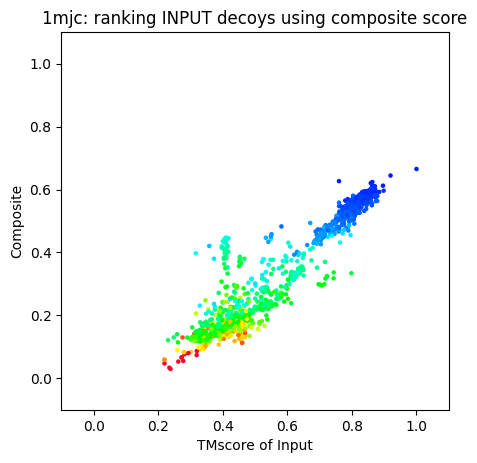

In [ ]:
plot_me(SCORES, x="tm_i", y="composite",
        title=f"{NAME}: ranking INPUT decoys using composite score")

0.9143006449691364


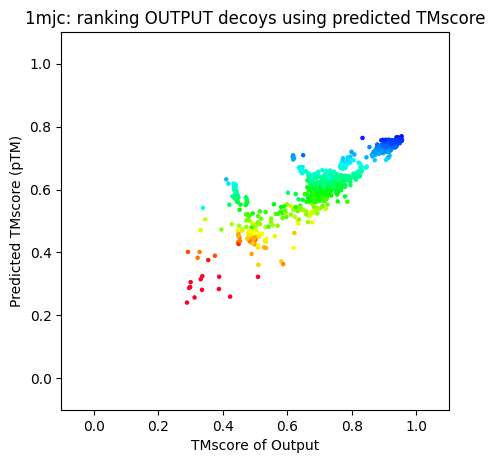

In [ ]:
plot_me(SCORES, x="tm_o", y="ptm",
        title=f"{NAME}: ranking OUTPUT decoys using predicted TMscore")

0.8287990333595944


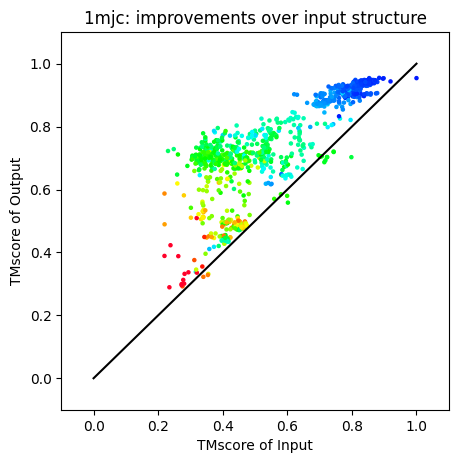

In [ ]:
plot_me(SCORES, x="tm_i", y="tm_o", diag=True,
        title=f"{NAME}: improvements over input structure")

## rank sequences
Example: ParD and ParE are an example of a toxin and antitoxin pair of proteins. If the pair of proteins bind, the organism survives, if they do not, organism does not! Mike Laub et al. created a library of mutants that targets this interface and their measured "fitness". Let's see how well AlphaFold can predict this, using the template trick.

In [ ]:
# get data
%shell wget -qnc https://files.ipd.uw.edu/krypton/5CEG_AD_trim.pdb
%shell wget -qnc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_A.csv
%shell wget -qnc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_B.csv

# lets parse the data
lib_a = dict([line.rstrip().split(",") for line in open("Library_fitness_vs_parE3_replicate_A.csv")])
lib_b = dict([line.rstrip().split(",") for line in open("Library_fitness_vs_parE3_replicate_B.csv")])
lib_ab = jax.tree_map(lambda a,b:(float(a)+float(b))/2,lib_a,lib_b)

# get sequences
seqs = {}
for mut,sco in lib_ab.items():
  seq = list("RHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTEVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLF")
  # mutate seq
  for i,m in zip([10,11,12,15],list(mut)): seq[i] = m
  seq = "".join(seq)
  seqs[mut] = {"seq":seq, "sco":sco}

NAME = "toxin"
if save_output_pdbs:
  os.makedirs(f"{NAME}_output",ok_exists=True)


In [ ]:
# setup model
clear_mem()
af = af2rank("5CEG_AD_trim.pdb", chain="A,B", model_name=SETTINGS["model_name"])
SCORES,LABELS = [],[]

In [ ]:
for label,x in seqs.items():
  if label not in LABELS:

    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",f"{label}.pdb")
    else:
      output_pdb = None

    score = af.predict(seq=x["seq"], **SETTINGS, output_pdb=output_pdb,
                       extras={"fitness":x["sco"], "id":label})
    SCORES.append(score)
    LABELS.append(label)

In [ ]:
plot_me(SCORES, x="fitness", y="composite", scale_axis=False)